# Future Sales Prediction

In [ ]:
'''

This script uses a time-series dataset consisting of daily sales of all 
products for a software company with multiple stores/branches (train set), 
evaluates several models on the train set, and uses the best model to predict 
the total sales for every product and store in the following month (test set).

'''

__author__ = "Mahsa Shokouhi"
__email__ = "mahsa_shokouhi@yahoo.com"

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

%matplotlib inline

pd.set_option('display.max_columns', 60)

## Define Functions

In [3]:
def get_info(df):
    ''' Overview of a dataframe '''
    print('Dimensions:', df.shape)
    print('\nThe first and last 3 lines:')

    return df.iloc[list(range(3))+list(range(-3, 0))]


def add_date_features(df):
    ''' Extract and add year, month, and season to features. '''
    df['year'] = df.date.map(lambda x: x.year)
    df['month'] = df.date.map(lambda x: x.month)
    df['season'] = ((df.month - 1) // 3) + 1

    return df


def mean_encode(df, feature, target):
    ''' Mean-encode selected feature with target: 
    add mean tartget value for each level of the feature.
    Then add them to the featues. '''

    kf = KFold(n_splits=5, random_state=None, shuffle=False)

    temp = [None] * df.shape[0]
    temp = pd.Series(temp)

    for idx_train, idx_val in kf.split(df):
        train = df.iloc[idx_train]
        validation = df.iloc[idx_val]

        means = train.groupby(feature)[target].mean()
        temp[idx_val] = validation[feature].map(means)

    df[feature + '_mean_encoded'] = temp
    mean_target = df[target].mean()
    df[feature + '_mean_encoded'].fillna(mean_target, inplace=True)

    # Correlation between mean_encoded feature and target
    encoded_feature = df[feature + '_mean_encoded'].values
    corr = np.corrcoef(df[target].values, encoded_feature)[0][1]
    print('Correlation between mean_encoded {} and target ='.format(feature), corr)

    return df


def aggregate_monthly(df, group_cols, agg_feature, agg_name, fill_na=0):
    ''' Aggregate to get total monthly resuluts for the selected feature.'''
    gb = df.groupby(group_cols, as_index=False)[
        agg_feature].agg({agg_name: sum})
    df_out = pd.merge(df, gb, how='left', on=group_cols).fillna(fill_na)

    return df_out


def clean_monthly_data(df, cols_to_drop):
    ''' Clean up aggregate_monthly results by 
    reformatting and removing daily data. '''
    # Reorder columns, and sort
    index_cols = ['shop_id', 'item_id', 'month_index']
    cols_other = list(df.columns.difference(index_cols))
    temp = df[index_cols + cols_other]
    df = temp

    # Remove duplicate rows corresponding to daily data (different days in 
    # the same month). Keep the most recent record (latest price).
    df.sort_values(index_cols + ['date'], inplace=True)
    df.drop_duplicates(subset=index_cols, keep='last', inplace=True)
    df = df.drop(['date'] + cols_to_drop, axis=1)
    df = df.reset_index(drop=True)
    
    return df


def add_lag_features(df, lag_cols, index_cols, max_lag):
    ''' Add data from previous months (lags) for the selected features
        to the list of features for training. '''
    temp1 = df.copy()[index_cols + lag_cols]

    for lag in np.arange(1, max_lag+1):
        temp2 = temp1.copy()
        temp2['month_index'] = temp2['month_index'] + lag
        col_name = '_lag' + str(lag)
        df = pd.merge(df, temp2, how='left', on=index_cols,
                      suffixes=('', col_name)).fillna(0)

    df.drop_duplicates(inplace=True)

    return df


def lag_cor_plot(data, col, n_lags):
    ''' Plot the changes and correlations of lagged-features (previous months) 
        with the current month values. '''
    n_rows = n_lags//3  # 3 columns
    plt.figure(figsize=(16, n_rows*4))  # hight=4 for each row
    x = col
    for i in range(1, n_lags+1):
        y = x + '_lag' + str(i)
        cor = np.corrcoef(data[x], data[y])[0, 1]

        ax = plt.subplot(n_rows, 3, i)
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        ax.tick_params(axis=u'both', which=u'both', length=0)
        ax.set_title('Correlation = %.2f' % cor)
        sns.scatterplot(x, y, data=data, ax=ax)


def get_train_test(df, target, cut_off):
    ''' Train-test split: keep the last month for test. '''
    max_months = max(df['month_index'])

    # remove old data (before cut_off value)
    train = df[df['month_index'].between(
        cut_off, max_months-1)].drop('month_index', axis=1)
    test = df[df['month_index'] ==
              max_months].drop('month_index', axis=1)

    x_train = train.drop(target, axis=1)
    y_train = train[target]

    x_test = test.drop(target, axis=1)
    y_test = test[target]

    return x_train, y_train, x_test, y_test

## Load Data

In [4]:
sales = pd.read_csv('data/sales_train.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')

test_data = pd.read_csv('data/test.csv')

## Data Wrangling

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
# Rename column "date_block_num"
sales = sales.rename(columns={'date_block_num': 'month_index'})

# Convert dates to datetime format
sales['date'] = pd.to_datetime(sales.date, format="%d.%m.%Y")

In [7]:
# Merge the training data
sales = pd.merge(sales, items, on='item_id',
                 how='left').drop('item_name', axis=1)
sales.describe()

,month_index,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [8]:
# Get transactions with negative 'item_price' or 'item_cnt_day'
price_negative = sales[sales['item_price'] <= 0]
count_negative = sales[sales['item_cnt_day'] < 0]

print(price_negative.shape, count_negative.shape)

(1, 7) (7356, 7)


In [9]:
# Remove the only row with negative price
# Items with negative count correspond to returns
idx = price_negative.index[0]
sales = sales.drop(idx, axis=0)

# Get separate columns for sales and returns
sales['return_cnt'] = abs(sales['item_cnt_day']) * \
    (sales['item_cnt_day'] < 0).astype(int)
sales['sell_cnt'] = abs(sales['item_cnt_day']) * \
    (sales['item_cnt_day'] > 0).astype(int)
sales = sales.drop('item_cnt_day', axis=1)

get_info(sales)

Dimensions: (2935848, 8)

The first and last 3 lines:


,date,month_index,shop_id,item_id,item_price,item_category_id,return_cnt,sell_cnt
0,2013-01-02,0,59,22154,999.0,37,0.0,1.0
1,2013-01-03,0,25,2552,899.0,58,0.0,1.0
2,2013-01-05,0,25,2552,899.0,58,1.0,0.0
2935846,2015-10-14,33,25,7459,349.0,55,0.0,1.0
2935847,2015-10-22,33,25,7440,299.0,57,0.0,1.0
2935848,2015-10-03,33,25,7460,299.0,55,0.0,1.0


## Exploratory Data Analysis

In [10]:
# Aggregate to get monthly data
sales = aggregate_monthly(sales,
                          ['month_index', 'shop_id', 'item_id'],
                          'sell_cnt', 'monthly_sale', fill_na=0)
sales = aggregate_monthly(sales,
                          ['month_index', 'shop_id', 'item_id'],
                          'return_cnt', 'monthly_return', fill_na=0)

# Net monthly sales
sales['sales_item_shop'] = (sales['monthly_sale']
                              - sales['monthly_return']).clip(lower=0)


# Clean-up the results: remove daily records and columns, sort, and reorder.
montly_sales = sales.copy()
cols_to_drop = ['sell_cnt', 'return_cnt', 'monthly_sale']
montly_sales = clean_monthly_data(montly_sales, cols_to_drop)


get_info(montly_sales)

Dimensions: (1609124, 7)

The first and last 3 lines:


,shop_id,item_id,month_index,item_category_id,item_price,monthly_return,sales_item_shop
0,0,30,1,40,265.0,0.0,31.0
1,0,31,1,37,434.0,0.0,11.0
2,0,32,0,40,221.0,0.0,6.0
1609121,59,22167,9,49,299.0,0.0,1.0
1609122,59,22167,11,49,299.0,0.0,2.0
1609123,59,22167,17,49,299.0,0.0,1.0


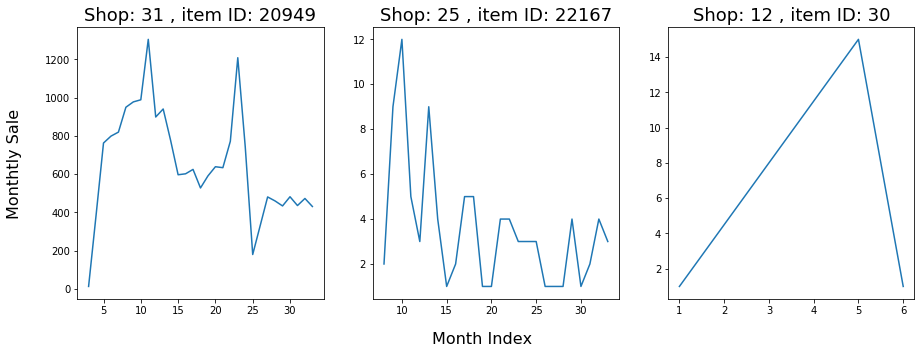

In [11]:
# Examples of montly sales of 3 differnt products at 3 stores

shops = [31, 25, 12]
items = [20949, 22167, 30]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.text(0.06, 0.5, 'Monthtly Sale', va='center',
         rotation='vertical', fontsize=16)
fig.text(0.5, 0, 'Month Index', ha='center', fontsize=16)
for i in range(3):
    df = montly_sales[(montly_sales['item_id'] == items[i]) &
                      (montly_sales['shop_id'] == shops[i])]
    sns.lineplot(x='month_index',
                 y='sales_item_shop', data=df, ax=axs[i])
    axs[i].set_title('Shop: ' + str(shops[i]) 
                     + ' , item ID: ' + str(items[i]), size=18)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

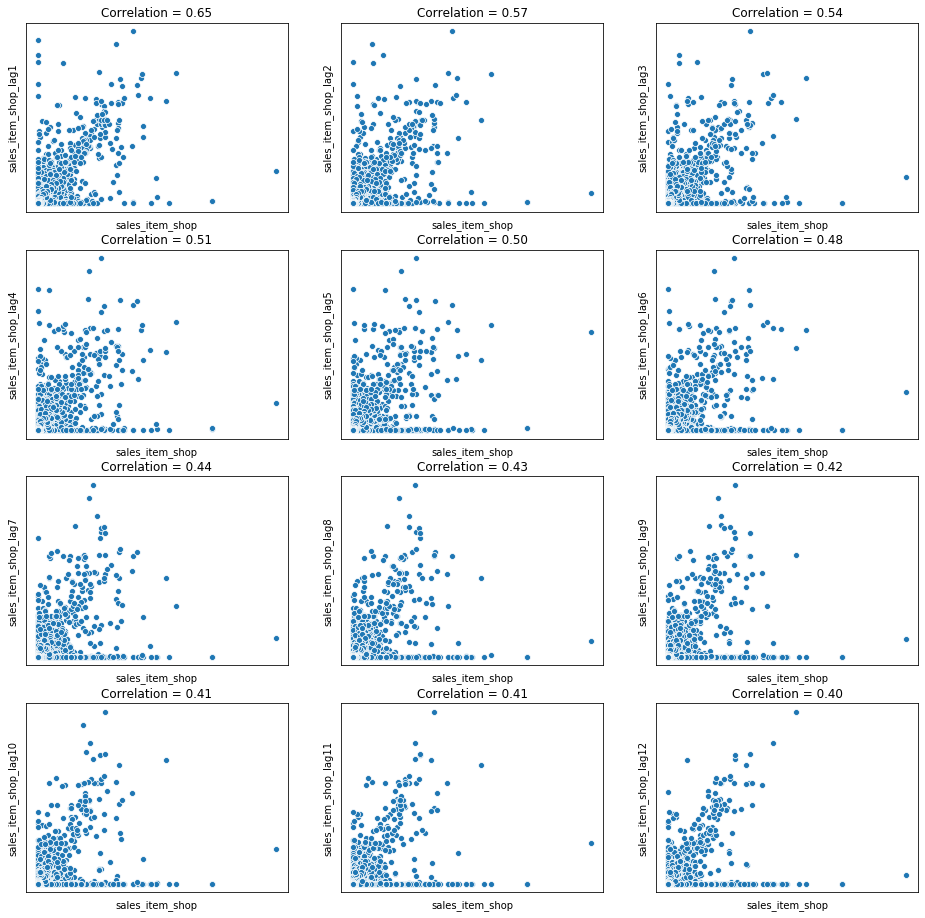

In [12]:
# Lag plots with 12-months lags of the monthly sale 

index_cols = ['shop_id', 'item_id', 'month_index']
lag_cols = ['sales_item_shop']
montly_sales = add_lag_features(montly_sales, lag_cols, index_cols, 12)

lag_cor_plot(montly_sales, 'sales_item_shop', 12)

## Baseline model
Monthly sale for each item, at each shop = total sale for the previous month

In [13]:
df_BL = montly_sales.copy()[['shop_id', 'item_id',
                      'month_index', 'sales_item_shop']]

target = 'sales_item_shop'
# Train-test split
x_train, y_train, x_test, y_test = get_train_test(df_BL, target, 12)


train_BL = pd.concat([x_train, y_train], axis=1)
train_BL = train_BL.drop_duplicates(subset=['shop_id', 'item_id'], keep='last')

test_BL = pd.concat([x_test, y_test], axis=1)
test_BL = pd.merge(test_BL, train_BL, how='left', on=[
    'shop_id', 'item_id']).dropna()


rmse_BLmodel = mean_squared_error(test_BL['sales_item_shop_x'],
                                  test_BL['sales_item_shop_y'], squared=False)
print('The root mean squared error of prediction with baseline model is:',
      rmse_BLmodel)

The root mean squared error of prediction with baseline model is: 14.503500272881032


## Feature Engineering

In [14]:
# Add month, year, and season to features
sales = add_date_features(sales)

# Get total monthly sales at each shop (all items), 
# and for each item (across all shops)

# Total monthly sale for all items at each shop
sales = aggregate_monthly(sales,
                          ['shop_id', 'month_index'],
                          'sell_cnt', 'sales_shop', fill_na=0)

# Total monthly sale for each item across all shops
sales = aggregate_monthly(sales,
                          ['item_id', 'month_index'],
                          'sell_cnt', 'sales_item', fill_na=0)


# Clean-up the results: remove daily records and columns, sort, and reorder.
cols_to_drop = ['sell_cnt', 'return_cnt', 'monthly_sale']
sales = clean_monthly_data(sales, cols_to_drop)


# Mean-encode 'item_id' and 'shop_id'
target = 'sales_item_shop'
sales = mean_encode(sales, 'shop_id', target)
sales = mean_encode(sales, 'item_id', target)


# Add 12-months lags of sales_item_shop, sales_shop, sales_item
index_cols = ['shop_id', 'item_id', 'month_index']
lag_cols = ['sales_item_shop', 'sales_shop', 'sales_item']
sales = add_lag_features(sales, lag_cols, index_cols, max_lag=12)


get_info(sales)

Correlation between mean_encoded shop_id and target = 0.012098052099900378
Correlation between mean_encoded item_id and target = 0.48420073393156327
Dimensions: (1609124, 50)

The first and last 3 lines:


,shop_id,item_id,month_index,item_category_id,item_price,month,monthly_return,sales_item,sales_item_shop,sales_shop,season,year,shop_id_mean_encoded,item_id_mean_encoded,sales_item_shop_lag1,sales_shop_lag1,sales_item_lag1,sales_item_shop_lag2,sales_shop_lag2,sales_item_lag2,sales_item_shop_lag3,sales_shop_lag3,sales_item_lag3,sales_item_shop_lag4,sales_shop_lag4,sales_item_lag4,sales_item_shop_lag5,sales_shop_lag5,sales_item_lag5,sales_item_shop_lag6,sales_shop_lag6,sales_item_lag6,sales_item_shop_lag7,sales_shop_lag7,sales_item_lag7,sales_item_shop_lag8,sales_shop_lag8,sales_item_lag8,sales_item_shop_lag9,sales_shop_lag9,sales_item_lag9,sales_item_shop_lag10,sales_shop_lag10,sales_item_lag10,sales_item_shop_lag11,sales_shop_lag11,sales_item_lag11,sales_item_shop_lag12,sales_shop_lag12,sales_item_lag12
0,0,30,1,40,265.0,2,0.0,862.0,31.0,6127.0,1,2013,2.267814,4.556410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,1,37,434.0,2,0.0,628.0,11.0,6127.0,1,2013,2.267814,2.974684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,0,40,221.0,1,0.0,299.0,6.0,5578.0,1,2013,2.267814,2.888325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1609121,59,22167,9,49,299.0,10,0.0,146.0,1.0,1754.0,4,2013,2.267814,3.112782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1609122,59,22167,11,49,299.0,12,0.0,83.0,2.0,2398.0,4,2013,2.267814,3.112782,0.0,0.0,0.0,1.0,1754.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1609123,59,22167,17,49,299.0,6,0.0,56.0,1.0,1158.0,2,2014,2.267814,3.112782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2398.0,83.0,0.0,0.0,0.0,1.0,1754.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


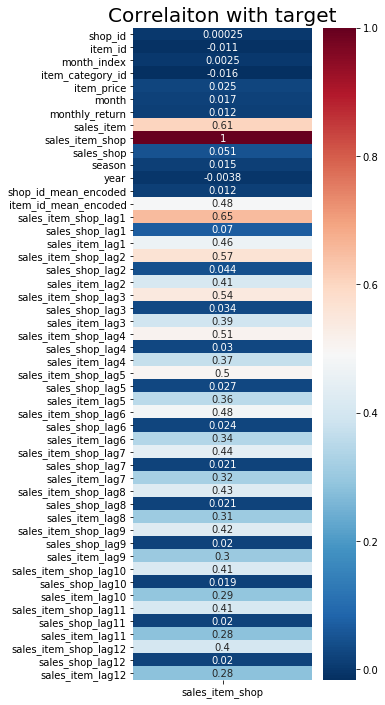

In [15]:
# Correlation of features with the target variable

df = pd.DataFrame(sales.corr().sales_item_shop, index=sales.corr().index)
plt.figure(figsize=(4, 12))
sns.heatmap(df, annot=True, cmap="RdBu_r");
plt.title('Correlaiton with target', fontsize=20);

## Create and Evaluate Models

In [16]:
# Train-test split: Keep the last month for test

target = 'sales_item_shop'
x_train, y_train, x_test, y_test = get_train_test(sales, target, 12)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((889869, 48), (889869,), (31531, 48), (31531,))

In [17]:
# Linear model

lr = make_pipeline(StandardScaler(), PCA(), LinearRegression())

crossval_lr = cross_val_score(lr, x_train, y_train,
                           cv=3, scoring='neg_mean_squared_error')

print('Root mean squared error with cross-validation:',
      sqrt(-1.0 * crossval_lr.mean()))

lr.fit(x_train, y_train)
pred_lr = lr.predict(x_test)
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
print('The root mean squared error of prediction with linear regression is:', rmse_lr)

Root mean squared error with cross-validation: 5.804411808739812
The root mean squared error of prediction with linear regression is: 12.017490179057498


In [18]:
# Light gradient boosting algorithm

lgbm = LGBMRegressor(feature_fraction=0.75,
                     min_data_in_leaf=2**5,
                     learning_rate=0.1,
                     bagging_seed=2**7,
                     num_leaves=2**7)

crossval_lgbm = cross_val_score(lgbm, x_train, y_train,
                                cv=3, scoring='neg_mean_squared_error')

print('Root mean squared error with cross-validation:',
      sqrt(-1.0 * crossval_lgbm.mean()))

lgbm.fit(x_train, y_train)
pred_lgbm = lgbm.predict(x_test)
rmse_lgbm = mean_squared_error(y_test, pred_lgbm, squared=False)
print(('The root mean squared error of prediction with '
      'light gradient boosting algorithm is:'), rmse_lgbm)

Root mean squared error with cross-validation: 5.297118761234895
The root mean squared error of prediction with light gradient boosting algorithm is: 10.213094925407018


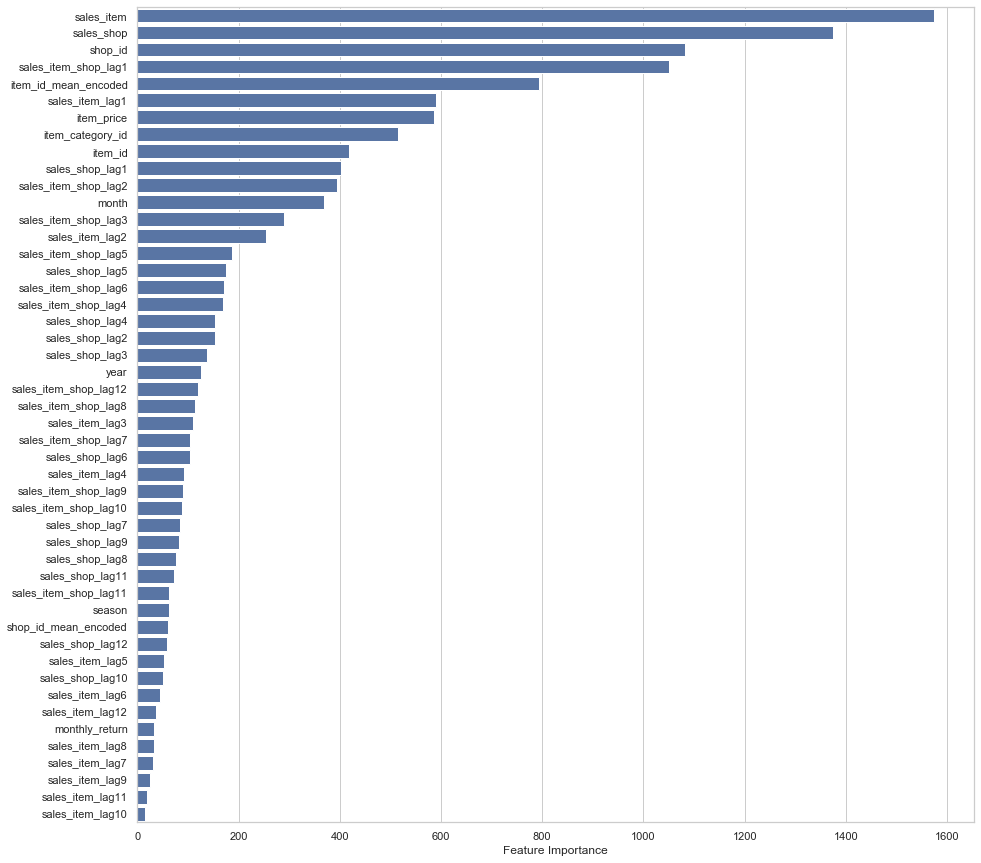

In [19]:
# Get Feature Importances

importances = lgbm.feature_importances_

feature_importance_df = pd.DataFrame(
    importances, columns=['Feature Importance'], index=x_test.columns)

feature_importance_df.sort_values(
    by='Feature Importance', ascending=False, inplace=True)

# Feature importance plot
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(x='Feature Importance', y=feature_importance_df.index,
            data=feature_importance_df, color="b");

## Predict Future Sales

In [20]:
get_info(test_data)

Dimensions: (214200, 3)

The first and last 3 lines:


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [21]:
# Reforemat test_data
test_data = test_data.drop('ID', axis=1)
test_data.sort_values(by=['shop_id', 'item_id'], inplace=True)
test_data = test_data.reset_index(drop=True)

get_info(test_data)

Dimensions: (214200, 2)

The first and last 3 lines:


,shop_id,item_id
0,2,30
1,2,31
2,2,32
214197,59,22164
214198,59,22166
214199,59,22167


In [23]:
# add features to test_data

lookup = sales.copy().drop_duplicates(
    subset=['shop_id', 'item_id'], keep='last')
lookup.drop(['month_index', 'sales_item_shop'], axis=1, inplace=True)

test = test_data.copy()
test = pd.merge(test, lookup, how='left',
                on=['shop_id', 'item_id']).fillna(0)

test['month'] = 11
test['year'] = 2015
test['season'] = 4

get_info(test)

Dimensions: (214200, 48)

The first and last 3 lines:


,shop_id,item_id,item_category_id,item_price,month,monthly_return,sales_item,sales_shop,season,year,shop_id_mean_encoded,item_id_mean_encoded,sales_item_shop_lag1,sales_shop_lag1,sales_item_lag1,sales_item_shop_lag2,sales_shop_lag2,sales_item_lag2,sales_item_shop_lag3,sales_shop_lag3,sales_item_lag3,sales_item_shop_lag4,sales_shop_lag4,sales_item_lag4,sales_item_shop_lag5,sales_shop_lag5,sales_item_lag5,sales_item_shop_lag6,sales_shop_lag6,sales_item_lag6,sales_item_shop_lag7,sales_shop_lag7,sales_item_lag7,sales_item_shop_lag8,sales_shop_lag8,sales_item_lag8,sales_item_shop_lag9,sales_shop_lag9,sales_item_lag9,sales_item_shop_lag10,sales_shop_lag10,sales_item_lag10,sales_item_shop_lag11,sales_shop_lag11,sales_item_lag11,sales_item_shop_lag12,sales_shop_lag12,sales_item_lag12
0,2,30,40.0,169.0,11,0.0,16.0,912.0,4,2015,2.267814,4.556410,1.0,800.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,832.0,49.0,0.0,0.0,0.0
1,2,31,37.0,399.0,11,0.0,18.0,727.0,4,2015,2.267814,2.974684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,32,40.0,149.0,11,0.0,30.0,943.0,4,2015,2.267814,2.888325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,766.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1923.0,40.0,0.0,0.0,0.0,2.0,946.0,37.0,2.0,922.0,37.0,0.0,0.0,0.0
214197,59,22164,37.0,699.0,11,0.0,12.0,998.0,4,2015,2.267814,3.129771,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1055.0,27.0,1.0,1204.0,92.0,2.0,1209.0,289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,59,22166,0.0,0.0,11,0.0,0.0,0.0,4,2015,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214199,59,22167,49.0,299.0,11,0.0,56.0,1158.0,4,2015,2.267814,3.112782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2398.0,83.0,0.0,0.0,0.0,1.0,1754.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
predictions = lgbm.predict(test)

In [ ]:
# Save results

with open('model.txt', 'w') as file:
    file.write(str(lgbm))


np.savetxt('predictions.csv', predictions, delimiter=',')

feature_importance_df.to_csv('feature_importance.csv')